## Manually colapse the events in images 

Collapse the events in the frames to get the most active pixels and get an 'artificial brightnest' of the image 


In [1]:
# Get system path 
import os
path = os.getcwd()
# Get parent directory
parent = os.path.dirname(path)
#Add parent directory to system path
os.sys.path.insert(0, parent)

from metavision_core.event_io import EventsIterator
import numpy as np
import matplotlib.pyplot as plt

from lib.utils import *
from lib.plot_utils import *   
from lib.event_processing import *
from lib.real_time_video import *

from metavision_core.event_io import EventsIterator
from metavision_sdk_core import PeriodicFrameGenerationAlgorithm
from metavision_sdk_ui import EventLoop, BaseWindow, Window, UIAction, UIKeyEvent

import cv2

#Dynamicaly reload modules in juptyer notebook
%load_ext autoreload 
%autoreload 2

In [8]:
# path = "../data/recordings/22_04/ra_50to60_de_70to80_10s_recording_2024-04-22.raw"

path = "../data/recordings/22_04/MAG_6_test.raw"
# path = "../data/recordings/02_02/recording_2024-02-02_17-26-59_FOV11.8_MAG6.raw"

mv_iterator = EventsIterator(input_path=path, delta_t=1000)

height, width = mv_iterator.get_size()  # Camera Geometry
event_frame_gen = PeriodicFrameGenerationAlgorithm(width, height, accumulation_time_us=100000)


# frames = np.random.randint(0, 256, size=(1, height, width), dtype=np.uint8)
frames = np.empty((0, height, width), dtype=np.uint8) 

def on_cd_frame_cb(ts, cd_frame):
    global frames  # Add this line to access the global frames variable
    gray_frame = np.reshape(cv2.cvtColor(cd_frame, cv2.COLOR_BGR2GRAY), (1, height, width))
    frames = np.append(frames,gray_frame, axis=0)  # Append the gray_frame as a new row to the frames array
    

event_frame_gen.set_output_callback(on_cd_frame_cb)

for evs in mv_iterator:
    event_frame_gen.process_events(evs)
    if len(frames) > 100:
        break 

print(frames.shape)


(72, 720, 1280)


In [11]:
# Compact the frames

max_buffer = 70
# blend = np.array(np.zeros((cv2.cvtColor(np.array(frames[0]), cv2.COLOR_BGR2GRAY).shape)))
copact_frames = []
frames_buffer = np.empty((0, height, width), dtype=np.uint8) 


st = time.perf_counter()
for i, _ in enumerate(frames):
    frames_buffer = np.append(frames_buffer, np.reshape(frames[i], (1, height, width)), axis=0)
    if frames_buffer.shape[0] == max_buffer:
        blend = blend_buffer(frames_buffer, mirror=True)
        copact_frames.append(blend.astype(np.uint8))
        frames_buffer = np.empty((0, height, width), dtype=np.uint8) 
print((time.perf_counter() - st)/frames.shape[0])


print(len(copact_frames))

0.055132776013888614
1


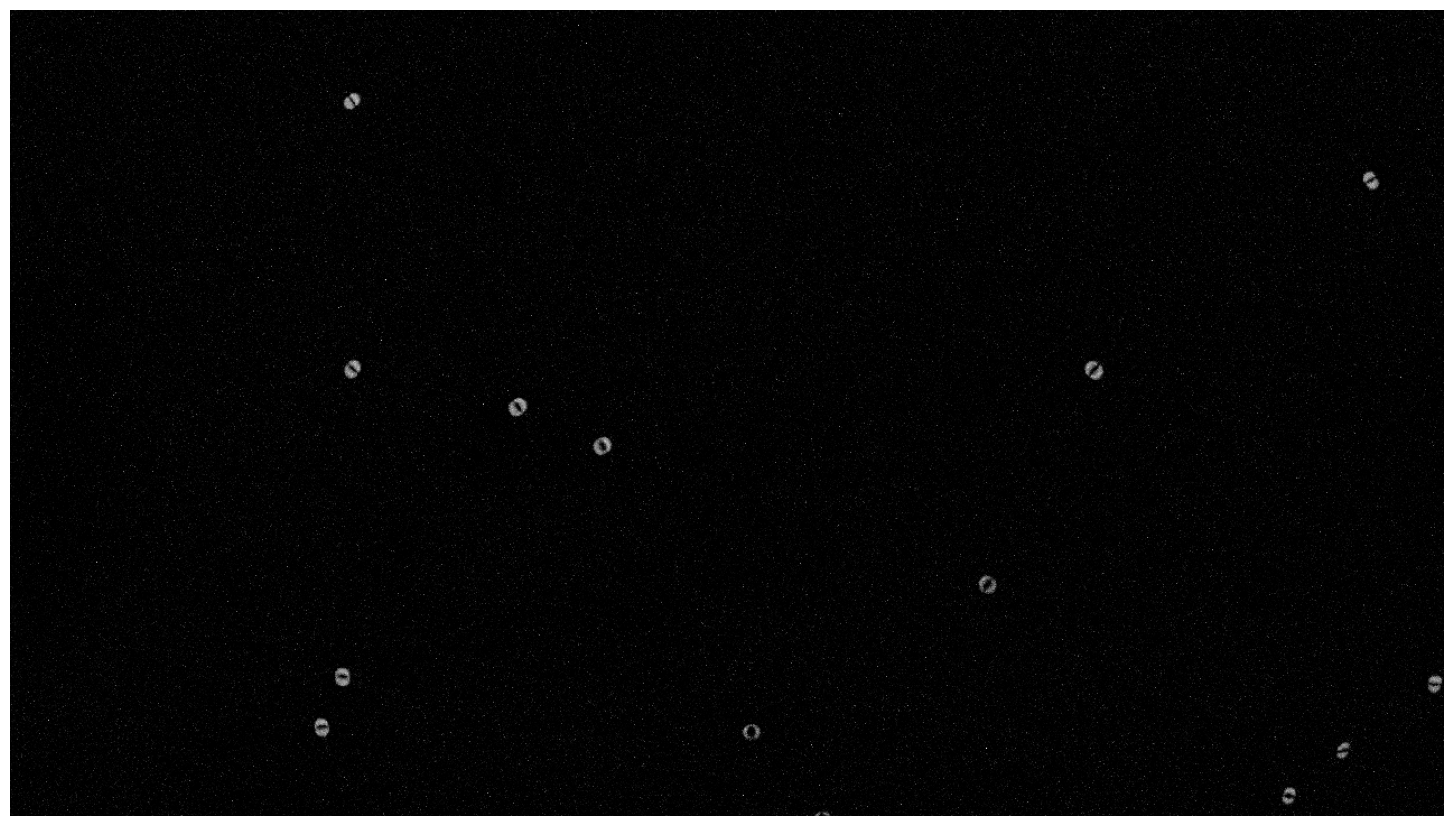

In [12]:
plot_image(copact_frames[0])

In [13]:
from lib.utils import *
from lib.event_processing import *

treshold = 0.3 # Percetange of max value 

filtered_frames = []
clusters_list = []
pixel_range = 15

for index, frame in  enumerate(copact_frames) :

    frame = cv2.blur(frame,(3,3))
    frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX)

    max_val = np.max(frame)
    frame_thr = cv2.threshold(frame, max_val*treshold, 1, cv2.THRESH_TOZERO)[1]
    filtered_frames.append(frame_thr)
    
    clusters =  max_value_cluster(frame_thr, pixel_range, 30)
    clusters = sorted(clusters, key=lambda x: x[1], reverse=True)
    clusters_index = np.array([cluster[0] for cluster in clusters])
    clusters_index = sorted(clusters_index, key=lambda x: x[1], reverse=True)
    clusters_list.append( index_cluster(frame, pixel_range, clusters_index) )

    # print('Frame: ', index ,' Original clusters: ', len(clusters_index))

# FOR NOISY IMAGES delete the clusters with a mass lower than a treshold
mass_treshold = 0.2
treshold_val = mass_treshold*np.max([cluster_mass[1] for cluster_mass in  clusters_list[0]])
clusters_list_filtered = [cluster for cluster in clusters_list[0] if cluster[1] > treshold_val ]

print('Original clusters: ', len(clusters_list[0]),'Fitered clusters: ',  len(clusters_list_filtered))

#JUST TO CHECK SOM WITHOUT FALSE STARS
# clusters_list_filtered.pop(2) # Remove the cluster 3 of the frame 12
# clusters_list_filtered.pop(5) # Remove the cluster 7(-1) of the frame 12




Original clusters:  14 Fitered clusters:  13


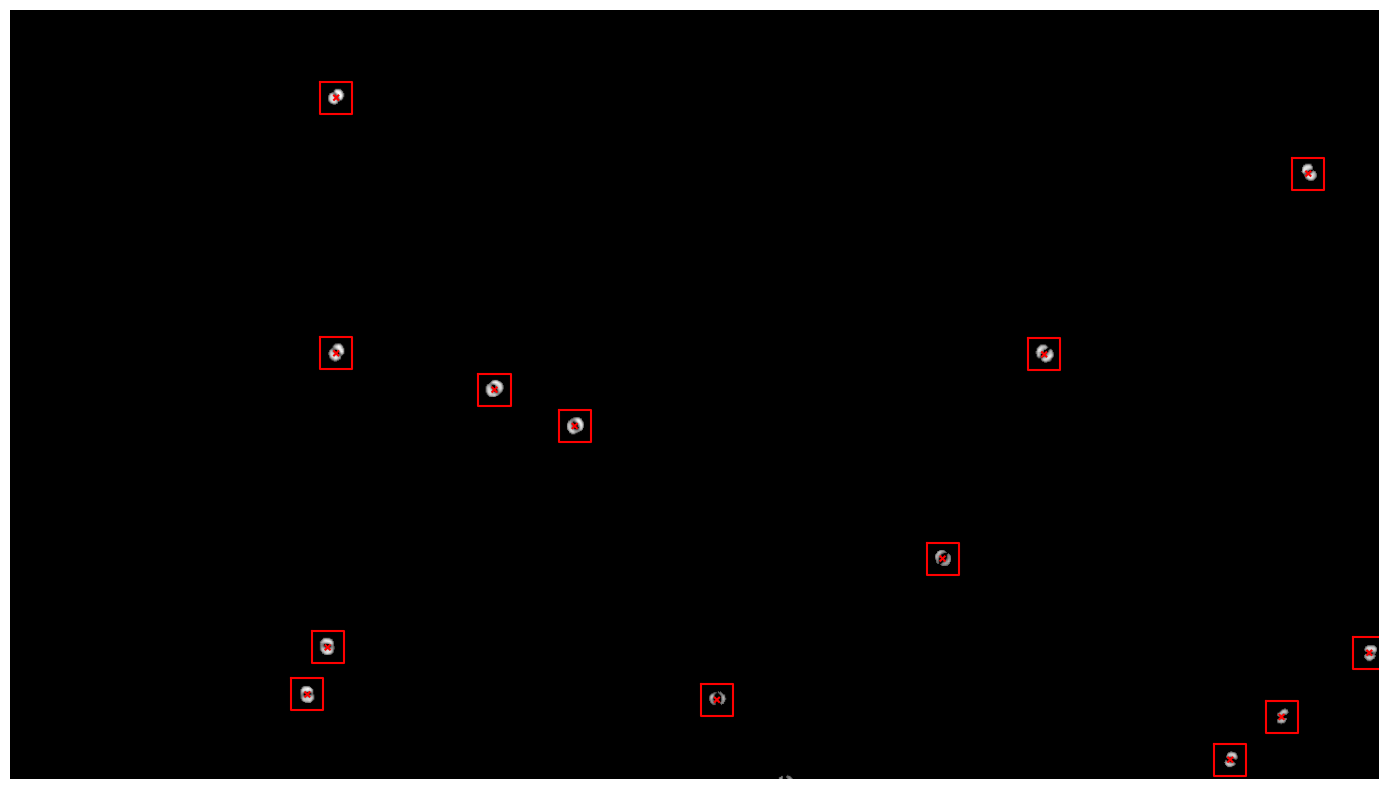

In [14]:
# FOR NOISY IMAGES delete the clusters with a mass lower than a treshold
mass_treshold = 0.2
treshold_val = mass_treshold*np.max([cluster_mass[1] for cluster_mass in  clusters_list[0]])
clusters_list_filtered = [cluster for cluster in clusters_list[0] if cluster[1] > treshold_val ]

plot_cluster(filtered_frames[0], [x[0] for x in clusters_list_filtered], pixel_range, [18.5,10])


## GET STAR FEATURES AND STAR CENTROID 

Image center:  [360. 640.]
Order by distance to the center of the image
Cluster 1 [array([389, 528]), 34413]: distance to center: 115.69356075426151
Cluster 2 [array([355, 453]), 37170]: distance to center: 187.06683297688022
Cluster 3 [array([513, 872]), 25078]: distance to center: 277.90825824361536
Cluster 4 [array([645, 661]), 19579]: distance to center: 285.7726368986366
Cluster 5 [array([322, 967]), 35047]: distance to center: 329.20054677961883
Cluster 6 [array([321, 305]), 34896]: distance to center: 337.262509034135
Cluster 7 [array([596, 297]), 33509]: distance to center: 416.3472108709268
Cluster 8 [array([ 82, 305]), 34094]: distance to center: 435.32631438956224
Cluster 9 [array([640, 278]), 32265]: distance to center: 457.65052168658127
Cluster 10 [array([ 701, 1141]), 22816]: distance to center: 606.0379526069304
Cluster 11 [array([ 153, 1214]), 31150]: distance to center: 610.1843983583979
Cluster 12 [array([ 661, 1189]), 20211]: distance to center: 626.1006308893163
Cl

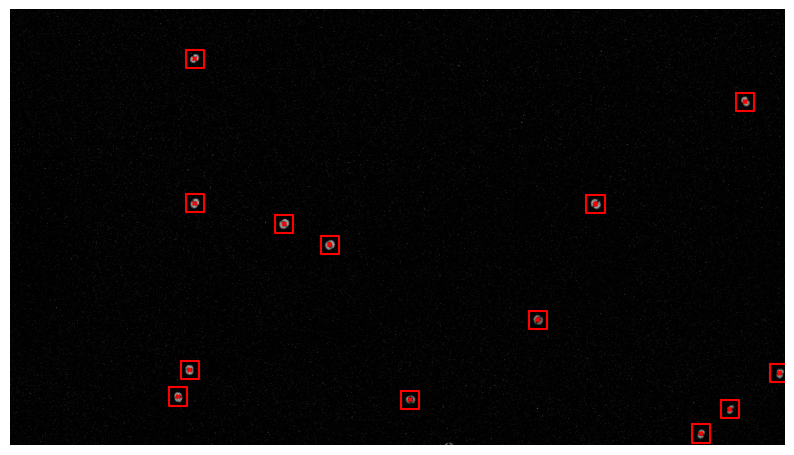

In [15]:
# Pop last value of each cluster (Previous cluster position)
# if len(clusters[0]) == 3:
    # [cluster.pop() for cluster in clusters]


clusters = clusters_list_filtered
# Get the clusters that are closest to the center of the image
clusters_sort, clusters_dist= order_by_center_dist([cluster for cluster in clusters ], copact_frames[0].shape)

print('Image center: ', np.array(frames[0].shape)/2)
print('Order by distance to the center of the image')
for i in range(len(clusters_sort)):
    print(f"Cluster {i+1} {clusters_sort[i][:2]}: distance to center: {clusters_dist[i]}")
# Plot the clusters on the image.

plot_cluster(copact_frames[0], [x[0] for x in clusters_sort], pixel_range)


# Speficic stars features check

Features 1 len:  8 , Features 2 len:  10
Main star:  [0.36956365 0.50161853]
Neighbours stars: 
   Star 1: [5.05893684 6.45548842] 
   Star 2: [4.57441895 4.34641053] 
   Star 3: [9.19158947 9.41959789] 
   Star 4: [8.49331368 4.23240632] 
[0.15997849 0.         1.20066611 0.12964639 1.41369009 2.47556904
 1.48618285 1.15628085]
[1.17348563 3.32232921 4.11109778 4.42019075 2.16401644 5.08574112
 4.09109256 6.8597007  3.92055263 5.2339799 ]


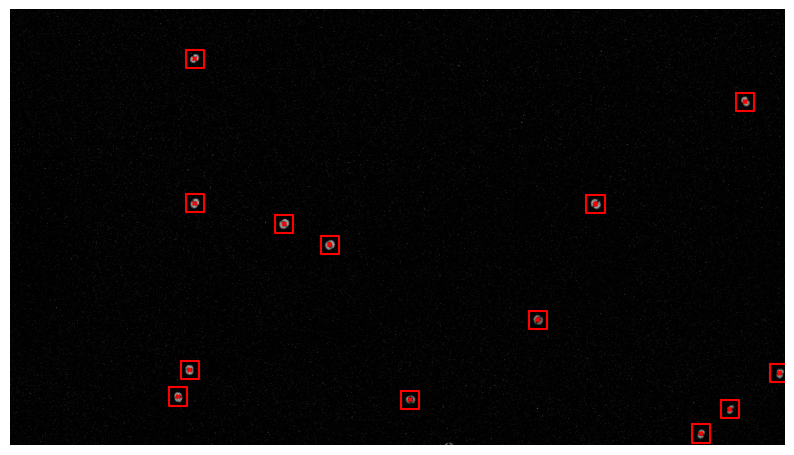

In [16]:
# Get the features of the selected main star 
from lib.event_processing import *

main_star = clusters_sort[0]
stars_sorted_by_main = order_by_main_dist(main_star, clusters_sort)


# ref_pixel_to_deg = 0.005319449742301844 /3.5#In degres from sun_calibration with FOV=reference_FOV
ref_pixel_to_deg = 0.0009500350877192982

reference_FOV = 1 #In degrees
recording_FOV = 15 #In degrees

num_of_neirbours = 4
stars_features_1, stars_features_2 = get_star_features([star[0] for star in 
        stars_sorted_by_main[0:num_of_neirbours+1]], ref_pixel_to_deg, reference_FOV, recording_FOV)

print('Features 1 len: ',len(stars_features_1), ', Features 2 len: ', len(stars_features_2))
print('Main star: ', clusters_sort[0][0] * ref_pixel_to_deg * reference_FOV)
print('Neighbours stars: ')
for i in range(1,5): 
    print(f"   Star {i}: {stars_sorted_by_main[i][0] * ref_pixel_to_deg * recording_FOV} ")
print(stars_features_1)
print(stars_features_2)

plot_cluster(copact_frames[0], [x[0] for x in stars_sorted_by_main], pixel_range)

# Load data


In [18]:
import pickle

mesh_size = 80
catalog_filter = 6 # Tycho catalog filter for brighness 

name = 'n80_tycho6'
# name = 'n78_88_tycho6'
# name = 'acc96_n89_89_tycho6_permutation_multi_permutation'

if name == None:
    name = 'n'+ str(mesh_size) +'_tycho' + str(catalog_filter)

#Load som from previusly trained model
with open('../data/SOM_parameters/'+name+'/som1_'+ name + '.p', 'rb') as infile:
    som1, som2 = pickle.load(infile)

#Load normalization parameters
with open('../data/SOM_parameters/'+name+'/normalization_parameters_tycho' + str(catalog_filter) + '.p', 'rb') as infile:
    norm_param = pickle.load(infile)

#Load dictionary with the star features
with open('../data/SOM_parameters/'+name+'/star_dict_'+ name + '.p', 'rb') as infile:
    star_dict_1, star_dict_2 = pickle.load(infile)

with open('../data/SOM_parameters/'+name+'/index_'+ name + '.p', 'rb') as infile:
    indices = pickle.load(infile)

# Predict stars

In [20]:
#Get the image postion
from lib.event_processing import *
import time


ref_pixel_to_deg = 0.0009501418439716312
reference_FOV = 1 #In degrees
recording_FOV = 15 #In degrees
num_of_neirbours = 4 

stars_data_df = get_star_dataset(type ='tycho', path = '../data/catalogs/tycho2_VT_6.csv')
if isinstance(stars_data_df, pd.DataFrame):
    # stars_data['data_number'] = stars_data.index
    stars_data = stars_data_df[['HIP','RA(ICRS)', 'DE(ICRS)']].values

feature_type_1 = 'permutation_angle_dist'
feature_type_2 = 'permutation'


features_vec_1 = []
features_vec_2 = []
predcited_stars = []
indices_image = []

time_start = time.time()
for main_star in clusters_sort:


    stars_sorted_by_main, index_sort = order_by_main_dist(main_star, clusters_sort, True)
    indices_image.append(index_sort[0:num_of_neirbours+1])

    if not_close_to_border(main_star[0], frame.shape, 70):
        #Order by distance to the main star at the loop
            
        # stars_features_1 = get_star_features_2(
        # [star[0] for star in stars_sorted_by_main[0:num_of_neirbours+1]],
        #     feature_type_1,
        #     ref_pixel_to_deg, reference_FOV, recording_FOV
        # )
        # stars_features_2 = get_star_features_2(
        #     [star[0] for star in stars_sorted_by_main[0:num_of_neirbours+1]],
        #     feature_type_2,
        #     ref_pixel_to_deg, reference_FOV, recording_FOV
        # )

        stars_features_1, stars_features_2 = get_star_features([star[0] for star in 
                stars_sorted_by_main[0:num_of_neirbours+1]], ref_pixel_to_deg, reference_FOV, recording_FOV)

        features_vec_1.append(stars_features_1)
        features_vec_2.append(stars_features_2)

        # Get prediction index
        predicted_star_ids_1 = predict_star_id(stars_features_1, norm_param[0:2], star_dict_1, som1)
        predicted_star_ids_2 = predict_star_id(stars_features_2, norm_param[2:4], star_dict_2, som2)
        # Get HIP of index
        hip_ids_predicted_1 = [stars_data[x][0].astype(int) for x in predicted_star_ids_1]
        hip_ids_predicted_2 = [stars_data[x][0].astype(int) for x in predicted_star_ids_2]


        if predicted_star_ids_1[0] == 0: # If no match of SOM1 (id returned is 0) use directly the SOM2 result
            star_guess = predicted_star_ids_2
        elif predicted_star_ids_2[0] == 0: # If no match of SOM2 (id returned is 0) use directly the SOM1 result
            star_guess = predicted_star_ids_1
        else:
            star_guess = list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))

        if len(star_guess) == 0: # Second guees 
            if len(predicted_star_ids_1) == 1 and len(predicted_star_ids_2) != 1:
                star_guess = (predicted_star_ids_1)
            elif len(predicted_star_ids_2) == 1 and len(predicted_star_ids_1) != 1:
                star_guess = (predicted_star_ids_2)
            elif len(predicted_star_ids_2) == 1 and len(predicted_star_ids_1) == 1:
                act_som1 = som1.activate( (stars_features_1 - norm_param[0])/(norm_param[1]-norm_param[0])  )
                act_som2 = som2.activate( (stars_features_2 - norm_param[2])/(norm_param[3]-norm_param[2]) )
                if act_som1.min() < act_som2.min():
                    star_guess = predicted_star_ids_1
                else:
                    star_guess = predicted_star_ids_2

        # Get the intersection of the two predictions if there is only one star in common
        if len(star_guess) == 1:
                    star_guess_index = star_guess[0]
                    star_guess_id = stars_data[star_guess_index].astype(int)[0]

        else:
            star_guess_index = None
            star_guess_id = None
            hip_ids_predicted_1 = None 
            hip_ids_predicted_2 = None 
    else:
        star_guess_index = None
        star_guess_id = None
        hip_ids_predicted_1 = None 
        hip_ids_predicted_2 = None 
        
    predcited_stars.append([hip_ids_predicted_1, hip_ids_predicted_2, star_guess_index, star_guess_id])


time_end = time.time()
print('Time to get predictions: ', time_end - time_start, 'average time: ', (time_end - time_start)/len(clusters_sort))
for i in range(len(predcited_stars)):
    print('Main star: ', clusters_sort[i][:2])
    print(' Predicted star ids 1: ', predcited_stars[i][0])
    print(' Predicted star ids 2: ', predcited_stars[i][1])
    print(' Predicted star id: ', predcited_stars[i][3], 'Index: ', predcited_stars[i][2])
    print('Neighbours stars indices: ', indices_image[i])
    # print(stars_data[predcited_stars[i][2]] if predcited_stars[i][2] is not None else 'No star found')

print('Ids vector: ', [x[3] for x in predcited_stars])

Time to get predictions:  0.04714059829711914 average time:  0.0036261998690091646
Main star:  [array([389, 528]), 34413]
 Predicted star ids 1:  [14135]
 Predicted star ids 2:  [14135]
 Predicted star id:  14135 Index:  0
Neighbours stars indices:  [0, 1, 5, 3, 6]
Main star:  [array([355, 453]), 37170]
 Predicted star ids 1:  [79072]
 Predicted star ids 2:  [14135]
 Predicted star id:  79072 Index:  2771
Neighbours stars indices:  [1, 0, 5, 6, 7]
Main star:  [array([513, 872]), 25078]
 Predicted star ids 1:  [7321]
 Predicted star ids 2:  [14135]
 Predicted star id:  7321 Index:  229
Neighbours stars indices:  [2, 4, 3, 9, 11]
Main star:  [array([645, 661]), 19579]
 Predicted star ids 1:  [71832]
 Predicted star ids 2:  [14135]
 Predicted star id:  71832 Index:  729
Neighbours stars indices:  [3, 2, 0, 1, 6]
Main star:  [array([322, 967]), 35047]
 Predicted star ids 1:  [56127]
 Predicted star ids 2:  [14135]
 Predicted star id:  56127 Index:  2407
Neighbours stars indices:  [4, 2, 10

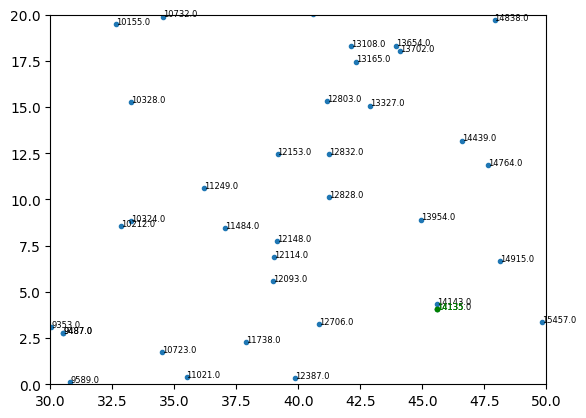

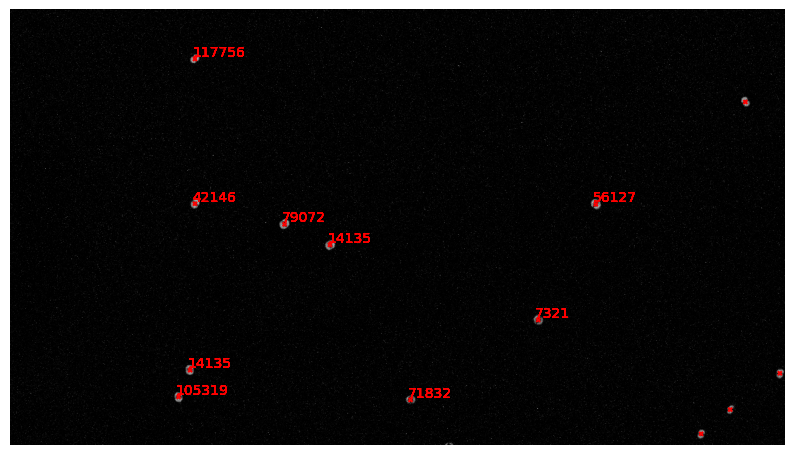

In [21]:
from lib.plot_utils import *
plt.figure()

x_range = [30, 50]
y_range = [0, 20]

#Plot the identification names of the set of stars in the range of the image
plt.plot([x[1] for x in stars_data],stars_data[:,2],'.')

# plt.plot([x[1] for x in stars_data],stars_data[:,2],'.')
# #Plot the identification names of the set of stars
for i in range(len(stars_data)):
    if stars_data[i,1] < x_range[1] and stars_data[i,1] > x_range[0] and stars_data[i,2] < y_range[1] and stars_data[i,2] > y_range[0]:
        plt.text(stars_data[i,1], stars_data[i,2], str((stars_data[i,0])) , fontsize=6)

x_range = [30, 50]
y_range = [0, 20]

not_none = [x[2] for x in predcited_stars if x[2] is not None]
stars_subdata = stars_data[not_none]
#Check that the stars are in range 
# stars_subdata = [x.tolist() for x in stars_subdata if np.round(x[1]) in range(x_range[0], x_range[1]) and np.round(x[2]) in range(y_range[0], y_range[1])]

plt.plot([x[1] for x in stars_subdata],stars_subdata[:,2],'.g')
#Plot the identification names of the sub set of stars
for i in range(len(stars_subdata)):
    if stars_subdata[i,1] < x_range[1] and stars_subdata[i,1] > x_range[0] and stars_subdata[i,2] < y_range[1] and stars_subdata[i,2] > y_range[0]:
        plt.text(stars_subdata[i,1], stars_subdata[i,2], str(int(stars_subdata[i,0])) , fontsize=6, color = 'g')

#change the limits of the axis
plt.xlim(x_range)
plt.ylim(y_range)

plt.show()

ids = []
for x in predcited_stars:
    ids.append(int(stars_data[x[2]][0]) if x[2] is not None else None)

plot_cluster_with_id(copact_frames[0], np.array(clusters_sort, dtype=object)[:,0], ids)

In [22]:
import time
time_start = time.time()
indices_neigh_gt  = np.full((len(predcited_stars),num_of_neirbours+1 ), None)
for i, predicted_star in enumerate(predcited_stars):
    if predicted_star[2] is not None:
       indices_neigh_gt[i]  = indices[predicted_star[2]]


indices_neigh_image = np.array([np.array(predcited_stars, dtype=object)[:,2][index] for index in indices_image], dtype=object)

print('Time: ', time.time()- time_start)

# time_start = time.time()
# indices_ids = [indices[predicted_star[2]] if predicted_star[2] is not None else None for predicted_star in predcited_stars]
# print('Time: ', time.time()- time_start)

print(len(indices_neigh_gt), len(indices_neigh_image))
for i in range(len(indices_neigh_gt)):
    if indices_neigh_gt[i][0] is not None:
      print('gt: ', indices_neigh_gt[i], 'image: ', indices_neigh_image[i])

Time:  0.002023458480834961
13 13
gt:  [0 1 2 2084 2085] image:  [0 2771 3717 729 0]
gt:  [2771 2772 2763 2765 2753] image:  [2771 0 3717 0 1532]
gt:  [229 230 227 247 248] image:  [229 2407 729 None None]
gt:  [729 732 730 731 2357] image:  [729 229 0 2771 0]
gt:  [2407 2408 2406 2410 2414] image:  [2407 229 None None None]
gt:  [3717 3718 3719 1924 3716] image:  [3717 2771 0 1532 0]
gt:  [0 1 2 2084 2085] image:  [0 4295 3717 2771 0]
gt:  [1532 1531 1522 1521 1530] image:  [1532 3717 2771 0 0]
gt:  [4295 4297 4296 4300 4301] image:  [4295 0 3717 2771 0]


In [23]:
time_start = time.time()
confirmed_stars_ids, _= check_star_id_by_neight( np.array(indices_neigh_gt, dtype=object),
                                               np.array(indices_neigh_image, dtype=object),
                                               np.array(indices_image, dtype=object),
                                               True)
time_end = time.time()

predict_star_ids = [x[2] for x in predcited_stars]

# # Create a vector of size 10 with all None values
# confirmed_stars = np.array([None]*len(predcited_stars))
# confirmed_stars[confirmed_stars_index] = np.array(predict_star_ids)[confirmed_stars_index]

print('Confirmed stars IDs', confirmed_stars_ids,'time', time_end - time_start)
print('Predicted ids: ', predict_star_ids)
# print('Confirmed stars: ', confirmed_stars)



Confirmed stars IDs [None None None None None None None None None None None None None] time 0.0005407333374023438
Predicted ids:  [0, 2771, 229, 729, 2407, 3717, 0, 1532, 4295, None, None, None, None]


Image center:  [360. 640.]
Star:  12828.0 position:  [1.28280000e+04 4.12349347e+01 1.01142161e+01] image position:  [385 585]
Star:  12832.0 position:  [1.28320000e+04 4.12396281e+01 1.24459558e+01] image position:  [232 673]
Star:  12153.0 position:  [12153.            39.15731611    12.44783972] image position:  [159 542]
Star:  13954.0 position:  [1.39540000e+04 4.49287383e+01 8.90739861e+00] image position:  [602 707]
Star:  12148.0 position:  [1.21480000e+04 3.91462592e+01 7.73007250e+00] image position:  [463 365]
Star:  13327.0 position:  [13327.            42.87320222    15.08212333] image position:  [129 865]
Star:  12803.0 position:  [12803.            41.13737917    15.31189667] image position:  [ 57 768]
Star:  12114.0 position:  [1.21140000e+04 3.90162336e+01 6.88356944e+00] image position:  [512 329]
Star:  11484.0 position:  [1.14840000e+04 3.70396656e+01 8.46008750e+00] image position:  [339 268]
Star:  11249.0 position:  [1.12490000e+04 3.62043561e+01 1.06105967e+01] 

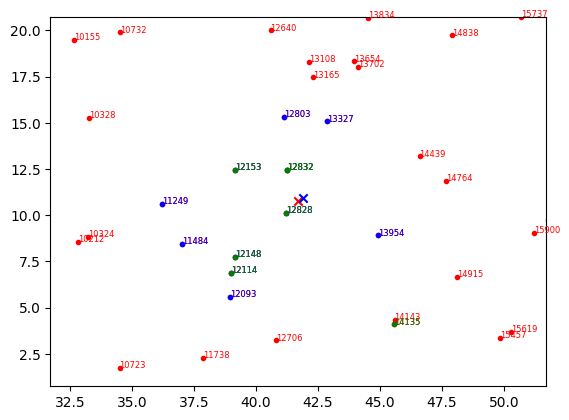

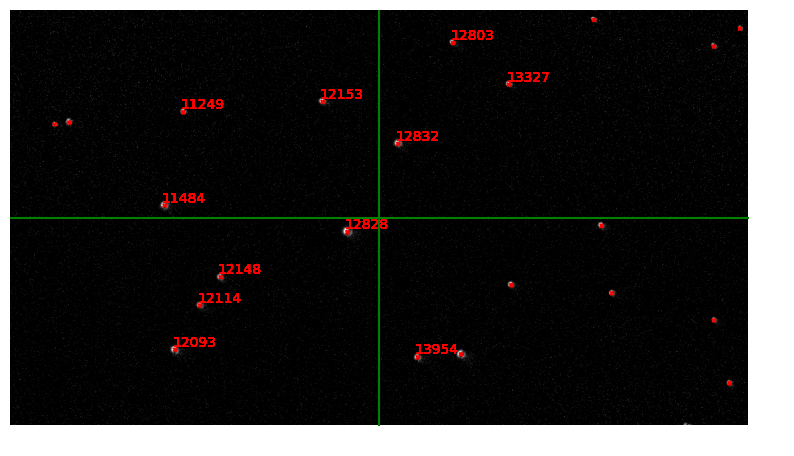

In [202]:
img_center = np.array(copact_frames[0].shape)/2

print('Image center: ', img_center)


#############################  Method 1 ######################################
confirmed_indices = [i for i in range(len(confirmed_stars_ids)) if confirmed_stars_ids[i] is not None]
distances = []
stars_position_tuple = []
for confirmed_index in confirmed_indices:
    dist_to_center = np.linalg.norm(img_center - clusters_sort[confirmed_index][0]) * ref_pixel_to_deg * recording_FOV / reference_FOV
    center_position = stars_data[confirmed_stars_ids[confirmed_index]][1:3] - dist_to_center* ref_pixel_to_deg * recording_FOV / reference_FOV
    print('Star: ', stars_data[confirmed_stars_ids[confirmed_index]][0], 'position: ', stars_data[confirmed_stars_ids[confirmed_index]]
          ,'image position: ', clusters_sort[confirmed_index][0])
    stars_position_tuple.append((stars_data[confirmed_stars_ids[confirmed_index]][1:3], clusters_sort[confirmed_index][0], stars_data[confirmed_stars_ids[confirmed_index]][0]))
    distances.append(dist_to_center)

x_c_solution, y_c_solution = solve_point_c(stars_data[confirmed_stars_ids[confirmed_indices].tolist()][:,1:3], distances)
center_solution = np.array([x_c_solution, y_c_solution])
print(' Center 1: ', center_solution)

#############################  Method 2 ######################################


img_center = np.array(frame.shape)/2
points_A = np.array([x[0] for x in clusters_sort])[confirmed_indices] * ref_pixel_to_deg * recording_FOV / reference_FOV
points_B = stars_data[list(confirmed_stars_ids[confirmed_indices])][:,1:3]
transformation_matrix = compute_transformation_matrix(points_A, points_B)
center_solution_2 = transform_point(img_center* ref_pixel_to_deg * recording_FOV / reference_FOV, transformation_matrix)
print(' Center 2: ', center_solution_2)

#############################  Method 2 ######################################


from lib.plot_utils import *
plt.figure()

visual_range = 10 
x_range = [x_c_solution -visual_range, x_c_solution +visual_range]
y_range = [y_c_solution -visual_range, y_c_solution +visual_range]

#Plot the identification names of the set of stars in the range of the image
plt.plot([x[1] for x in stars_data],stars_data[:,2],'.r')

# plt.plot([x[1] for x in stars_data],stars_data[:,2],'.')
# #Plot the identification names of the set of stars
for i in range(len(stars_data)):
    if stars_data[i,1] < x_range[1] and stars_data[i,1] > x_range[0] and stars_data[i,2] < y_range[1] and stars_data[i,2] > y_range[0]:
        plt.text(stars_data[i,1], stars_data[i,2], str(int(stars_data[i,0])) , fontsize=6, color = 'r')

# plot the sub set of stars that were confirmed 
stars_subdata = stars_data[[x for x in confirmed_stars_ids if x is not None]]
plt.plot([x[1] for x in stars_subdata],stars_subdata[:,2],'.b')
for i in range(len(stars_subdata)):
    if stars_subdata[i,1] < x_range[1] and stars_subdata[i,1] > x_range[0] and stars_subdata[i,2] < y_range[1] and stars_subdata[i,2] > y_range[0]:
        plt.text(stars_subdata[i,1], stars_subdata[i,2], str(int(stars_subdata[i,0])) , fontsize=6, color = 'b')

#Plot the identification names of the sub set of stars fistly identified
not_none = [x[2] for x in predcited_stars if x[2] is not None]
stars_subdata = stars_data[not_none]
plt.plot([x[1] for x in stars_subdata],stars_subdata[:,2],'.g')
for i in range(len(stars_subdata)):
    if stars_subdata[i,1] < x_range[1] and stars_subdata[i,1] > x_range[0] and stars_subdata[i,2] < y_range[1] and stars_subdata[i,2] > y_range[0]:
        plt.text(stars_subdata[i,1], stars_subdata[i,2], str(int(stars_subdata[i,0])) , fontsize=6, color = 'g')


#Plot the center of the image
plt.scatter(x_c_solution, y_c_solution, color='r', label='Center', marker='x')
plt.scatter(center_solution_2[0], center_solution_2[1], color='b', label='Center', marker='x')

#change the limits of the axis
plt.xlim(x_range)
plt.ylim(y_range)

plt.show() 

confirmed_stars_hip = [int(stars_data[x][0]) if x is not None else None for x in confirmed_stars_ids]
plot_cluster_with_id(copact_frames[0], np.array(clusters_sort, dtype=object)[:,0], confirmed_stars_hip, center = True)

In [158]:
original_ids = []
for x in predcited_stars:
    if x[2] in confirmed_stars_ids:
        original_ids.append(x[2])
    else:
        original_ids.append(None)

confirmed_stars_hip = [int(stars_data[x][0]) if x is not None else None for x in confirmed_stars_ids]
original_stars_hip = [int(stars_data[x][0]) if x is not None else None for x in original_ids]
stars_plot = plot_cluster_cv(copact_frames[0], np.array(clusters_sort, dtype=object)[:,0],confirmed_stars_hip,original_stars_hip, frame_position=center_solution,size = None, show_confirmed_ids = True)

cv_plot(stars_plot)
#save the image
cv2.imwrite('stars_identified_plot.png', stars_plot)

True

Rotated image computation 

In [159]:
# Compute the angles between the confirmed stars and the center of the image

from numpy import average


angles_tuple = []
for i in range(len(stars_position_tuple)):
    angle_deg = np.arctan2(stars_position_tuple[i][0][1] - center_solution[1], stars_position_tuple[i][0][0] - center_solution[0])
    angle_pix = np.arctan2(stars_position_tuple[i][1][1] - img_center[1], stars_position_tuple[i][1][0] - img_center[0])
    diff = (angle_deg-angle_pix + 2 * np.pi) % (2 * np.pi)
    angles_tuple.append(diff)
average_angle = average(angles_tuple)
print('Average angle: ', average_angle*180/np.pi)

Average angle:  300.80030938017256


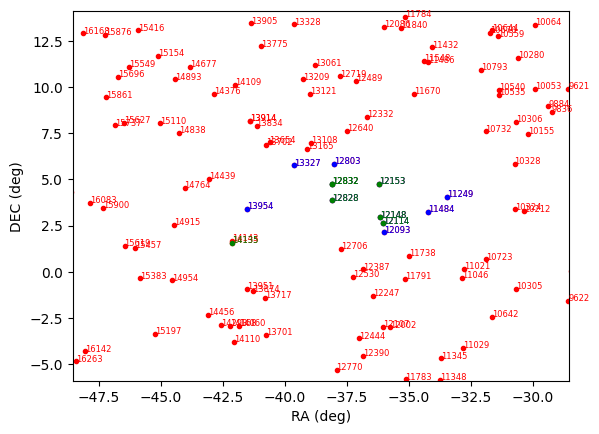

In [173]:
from lib.plot_utils import *
plt.figure()

angle = average_angle *0.97
angle = angle*180/np.pi 
stars_datar_roated = stars_data * np.array([1, np.cos(angle) , np.sin(angle)])

visual_range = 10
x_range = [x_c_solution*np.cos(angle) -visual_range, x_c_solution*np.cos(angle) +visual_range]
y_range = [y_c_solution*np.sin(angle) -visual_range, y_c_solution*np.sin(angle) +visual_range]

#Plot the identification names of the set of stars in the range of the image
plt.plot([x[1] for x in stars_datar_roated],stars_datar_roated[:,2],'.r')

# #Plot the identification names of the set of stars
for i in range(len(stars_datar_roated)):
    if stars_datar_roated[i,1] < x_range[1] and stars_datar_roated[i,1] > x_range[0] and stars_datar_roated[i,2] < y_range[1] and stars_datar_roated[i,2] > y_range[0]:
        plt.text(stars_datar_roated[i,1], stars_datar_roated[i,2], str(int(stars_datar_roated[i,0])) , fontsize=6, color= 'r')

# plot the sub set of stars that were confirmed 
stars_subdata = stars_datar_roated[[x for x in confirmed_stars_ids if x is not None]]
plt.plot([x[1] for x in stars_subdata],stars_subdata[:,2],'.b')
for i in range(len(stars_subdata)):
    if stars_subdata[i,1] < x_range[1] and stars_subdata[i,1] > x_range[0] and stars_subdata[i,2] < y_range[1] and stars_subdata[i,2] > y_range[0]:
        plt.text(stars_subdata[i,1], stars_subdata[i,2], str(int(stars_subdata[i,0])) , fontsize=6, color = 'b')

#Plot the identification names of the sub set of stars fistly identified
not_none = [x[2] for x in predcited_stars if x[2] is not None]
stars_subdata = stars_datar_roated[not_none]
plt.plot([x[1] for x in stars_subdata],stars_subdata[:,2],'.g')
for i in range(len(stars_subdata)):
    if stars_subdata[i,1] < x_range[1] and stars_subdata[i,1] > x_range[0] and stars_subdata[i,2] < y_range[1] and stars_subdata[i,2] > y_range[0]:
        plt.text(stars_subdata[i,1], stars_subdata[i,2], str(int(stars_subdata[i,0])) , fontsize=6, color = 'g')


#Plot the center of the image
plt.scatter(x_c_solution, y_c_solution, color='r', label='Center', marker='x')

#Plot a rectangle around the center rotated the average angle 
angle = average_angle *0.97
angle = angle*180/np.pi 
correct = 1.17
a = frame.shape[0]*pixel_to_deg*correct 
b = frame.shape[1]*pixel_to_deg
shaft = (a**2+b**2)**0.5 /2
rect = plt.Rectangle((x_c_solution -shaft, y_c_solution+1), a, b, angle=angle, edgecolor='r', facecolor='none')
# plt.gca().add_patch(rect)

#axis labels 
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')

#Size 
# plt.gcf().set_size_inches(10, 10)

#change the limits of the axis
plt.xlim(x_range)
plt.ylim(y_range)

plt.show() 

Real pixel to deg calculation: 

In [59]:
stars_position_tuple

# Calulate the diference between the image position and the catalog position
dist_vec = []
for i, main_star in enumerate(stars_position_tuple):
    dist_deg = []  
    dist_pix = [] 
    for k in range (len(stars_position_tuple)):
        if i != k:
            dist_deg.append( np.linalg.norm( main_star[0] - stars_position_tuple[k][0]) ) 
            dist_pix.append( np.linalg.norm( main_star[1] - stars_position_tuple[k][1]) )
    dist_vec.append(np.array(dist_deg)/ np.array(dist_pix))
    # print('Main star: ', main_star[0], np.array(dist_deg)/ np.array(dist_pix), 'deg/pix')
pixel_to_deg = ref_pixel_to_deg * recording_FOV/reference_FOV
print(f'mean: {np.mean(dist_vec)}, std: {np.std(dist_vec)}')
print(f'value used: {pixel_to_deg}')


# Position noise 
image_center  = np.array(copact_frames[9].shape)/2
pixel_noise = []
print('----- Position noise -----')
print('Center position: ', center_solution, image_center)
for i, main_star in enumerate(stars_position_tuple):
    gt_deg = np.linalg.norm(main_star[0]-center_solution)/pixel_to_deg
    obs_deg = np.linalg.norm(main_star[1]-image_center)
    pixel_noise.append(abs(gt_deg-obs_deg))
    print('Main star: ', main_star[2], 'gt: ', gt_deg, 'obs: ', obs_deg, 'diff: ', pixel_noise[i])
print(f'average pixel deviation {np.mean(pixel_noise)}')

mean: 0.22405640168345392, std: 0.300989109007814
value used: 0.013730028368794327
----- Position noise -----
Center position:  [122.66099414  -3.06136809] [360. 640.]
Main star:  12828.0 gt:  6007.645646574425 obs:  60.41522986797286 diff:  5947.230416706452
Main star:  12832.0 gt:  6036.765102291671 obs:  132.1854757528224 diff:  5904.579626538848
Main star:  12153.0 gt:  6185.8383440887255 obs:  223.61797781037194 diff:  5962.220366278354
Main star:  13954.0 gt:  5728.196410331461 obs:  251.10356429170812 diff:  5477.092846039754
Main star:  12148.0 gt:  6133.203798371084 obs:  293.65626163935275 diff:  5839.547536731731
Main star:  94434.0 gt:  12178.702180685746 obs:  322.4686031228467 diff:  11856.2335775629
Main star:  12803.0 gt:  6086.5420544987555 obs:  328.92704358261574 diff:  5757.61501091614
Main star:  12114.0 gt:  6135.011880534913 obs:  346.1574786134195 diff:  5788.854401921493
Main star:  11484.0 gt:  6292.268953734344 obs:  372.5922704512266 diff:  5919.676683283117

Stars per 15-15 fov: 



In [ ]:
import numpy as np

# Function to generate random star positions
def generate_star_positions(num_stars, max_x, max_y):
    return np.random.randint(0, max_x, num_stars), np.random.randint(0, max_y, num_stars)

# Function to calculate average stars in each 15x15 ideal image
def calculate_average_stars(star_positions, max_x, max_y):
    averages = np.zeros((max_x // 15, max_y // 15))  # Initialize array for averages
    for i in range(0, max_x, 15):
        for j in range(0, max_y, 15):
            # Count stars in the current 15x15 area
            count = np.sum((star_positions[0] >= i) & (star_positions[0] < i + 15) & 
                           (star_positions[1] >= j) & (star_positions[1] < j + 15))
            # Calculate average and store in the array
            averages[i // 15, j // 15] = count / 225  # 15x15 area has 225 pixels
    return averages

# Parameters
num_stars = 1000  # Number of stars
max_x = 360  # Maximum x-coordinate
max_y = 180  # Maximum y-coordinate

# Generate random star positions
star_positions = generate_star_positions(num_stars, max_x, max_y)


[[ 4. 10. 14.  8. 21. 18.  9. 18. 15. 21. 18.  1.]
 [ 2.  5. 14. 12. 10. 16. 11. 23. 19. 16. 16.  2.]
 [ 2.  9.  7. 15. 14. 19. 20. 30. 24. 16.  9.  4.]
 [ 3.  9.  6. 12. 18. 26. 17. 26. 25. 29. 13.  4.]
 [ 3. 10.  6. 12. 16. 28. 43. 46. 16. 21.  7.  6.]
 [ 3.  8. 11. 24. 22. 50. 37. 32. 25. 11.  6.  2.]
 [ 2. 11. 18. 36. 32. 40. 33. 23. 14. 18.  6.  2.]
 [ 1. 10. 30. 50. 56. 30. 26. 31. 13. 16.  2.  3.]
 [ 6. 15. 53. 33. 21. 19. 22. 24.  8. 10. 10.  2.]
 [ 3. 17. 35. 25. 19. 19. 18. 11. 15. 16. 12.  1.]
 [ 5. 21. 31. 14. 12. 18. 13. 11. 22.  9.  6.  3.]
 [ 2. 26. 20. 18. 13. 12. 21. 12. 13.  8.  5.  0.]
 [ 4. 24. 28. 18. 15. 17. 13. 25.  9.  8.  9.  5.]
 [ 2. 17. 25. 22. 17. 14. 15. 16. 14. 12.  3.  1.]
 [ 6. 10. 24. 19. 24. 15. 18. 15.  9. 12.  4.  3.]
 [ 5. 18. 22. 32. 33. 16. 17. 22. 22. 13.  9.  2.]
 [ 4. 12. 25. 32. 30. 17. 21. 16. 17. 13.  7.  5.]
 [ 0.  8. 21. 30. 22. 14. 17. 28. 16. 15. 10.  4.]
 [ 3. 14. 15. 30. 37. 27. 24. 32. 28. 12.  8.  4.]
 [ 0.  5. 12. 19. 32. 22. 29. 3

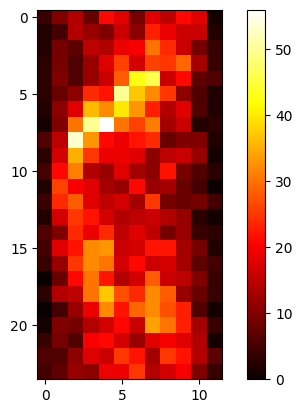

In [151]:


# Get the average star number in a 15x15 angle range of the stars in stars_data

if isinstance(stars_data_df, pd.DataFrame):
    # stars_data['data_number'] = stars_data.index
    position_stars_data = stars_data_df[['RA(ICRS)', 'DE(ICRS)']].values

position_stars_data[:,1]+=90

def calculate_average_stars(star_positions, max_x, max_y):
    averages = np.zeros((max_x // 15, max_y // 15))  # Initialize array for averages
    for i in range(0, max_x, 15):
        for j in range(0, max_y, 15):
            # Count stars in the current 15x15 area
            count = np.sum((star_positions[:,0] >= i) & (star_positions[:,0] < i + 15) & 
                           (star_positions[:,1] >= j) & (star_positions[:,1] < j + 15))
            # Calculate average and store in the array
            averages[i // 15, j // 15] = count   # 15x15 area has 225 pixels
    return averages

averages = calculate_average_stars(position_stars_data, 360, 180)
print(averages)

# generate a set of n random stars in each cuadrant 
# n = 1
# max_x = 360
# max_y = 180
# star_positions = np.empty((0,2), int)
# for i in range(4):
#     star_positions = np.append(star_positions, np.random.randint(0, max_x, (n,2)), axis=0)

# Plot a heat map of the number of stars
plt.imshow(averages, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()


[[ 0.  2.  2.  1.  4.  3.  1.  3.  3.  4.  3.  0.]
 [ 0.  1.  2.  2.  2.  3.  2.  4.  3.  3.  3.  0.]
 [ 0.  1.  1.  3.  2.  3.  4.  6.  4.  3.  1.  0.]
 [ 0.  1.  1.  2.  3.  5.  3.  5.  5.  5.  2.  0.]
 [ 0.  2.  1.  2.  3.  5.  8.  9.  3.  4.  1.  1.]
 [ 0.  1.  2.  4.  4. 10.  7.  6.  5.  2.  1.  0.]
 [ 0.  2.  3.  7.  6.  8.  6.  4.  2.  3.  1.  0.]
 [ 0.  2.  6. 10. 11.  6.  5.  6.  2.  3.  0.  0.]
 [ 1.  3. 10.  6.  4.  3.  4.  4.  1.  2.  2.  0.]
 [ 0.  3.  7.  5.  3.  3.  3.  2.  3.  3.  2.  0.]
 [ 1.  4.  6.  2.  2.  3.  2.  2.  4.  1.  1.  0.]
 [ 0.  5.  4.  3.  2.  2.  4.  2.  2.  1.  1.  0.]
 [ 0.  4.  5.  3.  3.  3.  2.  5.  1.  1.  1.  1.]
 [ 0.  3.  5.  4.  3.  2.  3.  3.  2.  2.  0.  0.]
 [ 1.  2.  4.  3.  4.  3.  3.  3.  1.  2.  0.  0.]
 [ 1.  3.  4.  6.  6.  3.  3.  4.  4.  2.  1.  0.]
 [ 0.  2.  5.  6.  6.  3.  4.  3.  3.  2.  1.  1.]
 [ 0.  1.  4.  6.  4.  2.  3.  5.  3.  3.  2.  0.]
 [ 0.  2.  3.  6.  7.  5.  4.  6.  5.  2.  1.  0.]
 [ 0.  1.  2.  3.  6.  4.  5.  

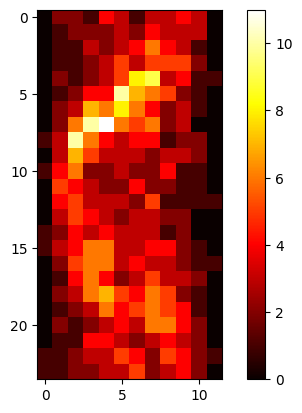

In [153]:
print(averages // 5)
plt.imshow(averages// 5, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [147]:
def generate_false_stars( max_x, max_y):
    flase_stars  = []
    for i in range(0, max_x, 15):
        for j in range(0, max_y, 15):
            #Genrate random stars in the 15x15 area
                random_pos_x = np.random.randint(i, i+15)
                random_pos_y = np.random.randint(j, j+15)
                flase_stars.append(np.array([random_pos_x, random_pos_y]))
    return np.array(flase_stars)

n = 5 
test_ = generate_false_stars(360, 180)
for i in range(n-1):
    test_ = np.append(test_, generate_false_stars(360, 180), axis=0)

# test_ = generate_false_stars(360, 180)
print(test_.shape)
print(calculate_average_stars(test_, 360, 180))

(1440, 2)
[[5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]]


In [148]:
# ---------------------------------------------------------------------------- #
# --------------------------------- LOAD SOM --------------------------------- #    
# ---------------------------------------------------------------------------- #
import pickle

mesh_size = 80
catalog_filter = 6
name = 'n'+ str(mesh_size) +'_tycho' + str(catalog_filter)

name = 'n78_88_tycho6'

#Load som from previusly trained model
with open('../data/SOM_parameters/'+name+'/som1_'+ name + '.p', 'rb') as infile:
    som1, som2 = pickle.load(infile)

#Load normalization parameters
with open('../data/SOM_parameters/'+name+'/normalization_parameters_tycho' + str(name[-1]) + '.p', 'rb') as infile:
    norm_param = pickle.load(infile)

#Load dictionary with the star features
with open('../data/SOM_parameters/'+name+'/star_dict_'+ name + '.p', 'rb') as infile:
    star_dict_1, star_dict_2 = pickle.load(infile)

In [169]:
import time 
from lib.event_processing import *
from lib.som_training import *

from scipy.spatial import KDTree


cont = np.zeros(6) # [Correct match, wrong match, multiple match, no macht(match 2 bad), no macht(match 1 bad), no macht(both mach bad)]
cont_no_match = np.zeros(3) # [no match 1, no match 2, no match both]
acc = np.zeros(2) # [correct SOM1, correct SOM2]


if isinstance(stars_data_df, pd.DataFrame):
    # stars_data['data_number'] = stars_data.index
    stars_pos = stars_data_df[['RA(ICRS)', 'DE(ICRS)']].values

original_shape = stars_pos.shape[0]

n_false_stars = 1 
false_stars = generate_false_stars(360, 180)
for i in range(n_false_stars-1):
    false_stars = np.append(false_stars, generate_false_stars(360, 180), axis=0)

false_stars[:,1] -= 90 # Set +-90 range 
stars_pos = np.append(stars_pos, false_stars, axis=0)


n_of_neighbor = 4
tree = KDTree(stars_pos)
_, indices = tree.query(stars_pos, k=n_of_neighbor+1)

# Pixel scaled noise #SET TO 0 for false stars 

time_start = time.time()

som1_activate_data = []
som2_activate_data = []

features_1_noisy = []
features_2_noisy = []

for i in range(original_shape):
    features_1 = get_star_features_2(stars_pos[indices[i][0:n_of_neighbor+1]], feature_type_1)
    features_2 = get_star_features_2(stars_pos[indices[i][0:n_of_neighbor+1]], feature_type_2)
        
    # features_1, features_2 = get_star_features(stars_pos[indices[i][0:n_of_neighbor+1]], 1, 1, 1)
    # feature_type_1 = 'permutation_multi'
    # feature_type_2 = 'permutation'

    features_1_noisy.append(features_1) 
    features_2_noisy.append(features_2)

    winner_ids_1 = predict_star_id(features_1, norm_param[0:2], star_dict_1, som1)
    winner_ids_2 = predict_star_id(features_2, norm_param[2:4], star_dict_2, som2)

    if i in winner_ids_1 and len(winner_ids_1) < 20:
        acc[0] += 1
    if i in winner_ids_2 and len(winner_ids_2) < 20:
        acc[1] += 1
    

    if winner_ids_1[0] == 0: # If no match of SOM1 (id returned is 0) use directly the SOM2 result
        star_guess = winner_ids_2
    elif winner_ids_2[0] == 0: # If no match of SOM2 (id returned is 0) use directly the SOM1 result
        star_guess = winner_ids_1
    else:
        star_guess = list(set(winner_ids_1).intersection(winner_ids_2))

    if len(star_guess) == 0: # Second guees 
        if len(winner_ids_1) == 1 and len(winner_ids_2) != 1:
            star_guess = (winner_ids_1)
        elif len(winner_ids_2) == 1 and len(winner_ids_1) != 1:
            star_guess = (winner_ids_2)
        elif len(winner_ids_2) == 1 and len(winner_ids_1) == 1:
            act_som1 = som1.activate( (features_1 - norm_param[0])/(norm_param[1]-norm_param[0]) )
            act_som2 = som2.activate( (features_2 - norm_param[2])/(norm_param[3]-norm_param[2]) )
            if act_som1.min() < act_som2.min():
                star_guess = winner_ids_1
            else:
                star_guess = winner_ids_2

    # Accuracy count
    if len(star_guess) == 1:
        cont[0] += star_guess[0] == i
        cont[1] += star_guess[0] != i
    else:
        # print("Error: ", list(set(winner_ids_1).intersection(winner_ids_2)), "!=", i)
        if len(star_guess) == 0: # If no match

            # act_som1 = som1.activate( (features_1 - norm_param[0])/(norm_param[1]-norm_param[0]) )
            # act_som2 = som2.activate( (features_2 - norm_param[2])/(norm_param[3]-norm_param[2]) )
            # som1_activate_data.append([act_som1.min(), act_som1.max(), act_som1.mean()])
            # som2_activate_data.append([act_som2.min(), act_som2.max(), act_som2.mean()])

            if i in winner_ids_1:
                cont[3] += 1
            elif i in winner_ids_2:
                cont[4] += 1
            else:  
                cont[5] += 1

            # print("gt:", i)
            # print("ids 1:", winner_ids_1, "activation: ", act_som1.min() ) 
            # print("ids 2:", winner_ids_2, "activation: ", act_som2.min() )
            # print('----------------------')

            if len(winner_ids_1) == 1 and len(winner_ids_2) == 1:
                if i in winner_ids_1 and act_som1.min() < act_som2.min():
                    cont_no_match[0] += 1
                elif i in winner_ids_2 and act_som2.min() < act_som1.min():
                    cont_no_match[1] += 1
                else:
                    cont_no_match[2] += 1
                


        cont[2] += len(star_guess) > 1
time_end = time.time()


print('number of cases:', np.sum(cont[0:6]), 'len: ', len(stars_pos))
print('original shape:', original_shape, 'total shape : ', stars_pos.shape[0], 'false stars: ', false_stars.shape[0])
np.set_printoptions(formatter={'float': '{: 0.5f}'.format})
print(f"total success = {cont[0:6] / np.sum(cont[0:6])} = {np.sum(cont[0:6]) / original_shape}")
print("               ", "[ CORRECT  ,   WRONG  ,  MULTIPLE, NO MATCH(2º bad), NO MATCH(1º bad), NO MATCH(BOTH)]")
print('SOM1 success:', acc[0] / np.sum(cont[0:6]), ' SOM2 success:', acc[1] / np.sum(cont[0:6]))
# print('No match: ', cont_no_match / sum(cont_no_match), sum(cont_no_match)/stars_pos.shape[0] )
print("total time=",  time_end - time_start)
print("total time per star=",  (time_end - time_start) / np.sum(cont[0:6]))


number of cases: 4566.0 len:  4854
original shape: 4566 total shape :  4854 false stars:  288
total success = [ 0.78296  0.20696  0.00964  0.00000  0.00000  0.00044] = 1.0
                [ CORRECT  ,   WRONG  ,  MULTIPLE, NO MATCH(2º bad), NO MATCH(1º bad), NO MATCH(BOTH)]
SOM1 success: 0.7825229960578186  SOM2 success: 0.7853701270258432
total time= 8.63347840309143
total time per star= 0.0018908187479394285


In [177]:
import time 
from lib.event_processing import predict_star_id


cont = np.zeros(6) # [Correct match, wrong match, multiple match, no macht(match 2 bad), no macht(match 1 bad), no macht(both mach bad)]
cont_no_match = np.zeros(3) # [no match 1, no match 2, no match both]
acc = np.zeros(2) # [correct SOM1, correct SOM2]

if isinstance(stars_data_df, pd.DataFrame):
    # stars_data['data_number'] = stars_data.index
    stars_pos = stars_data_df[['RA(ICRS)', 'DE(ICRS)']].values

n_of_neighbor = 4
tree = KDTree(stars_pos)
_, indices = tree.query(stars_pos, k=n_of_neighbor+1)

# Random scale noise 
# noise= np.random.normal(loc=1, scale=0.001, size=stars_pos.shape)
# stars_pos *= noise
# mean_noise = np.mean(np.abs(1-noise), axis=0)
# mean_time = 0

# Pixel scaled noise
noise = generate_pixel_noise(stars_data.shape, 5)
mean_noise = np.mean( np.linalg.norm(stars_data[:,1:3]-(stars_pos+noise), axis=1))
stars_pos += noise

mean_time = 0

time_start = time.time()

som1_activate_data = []
som2_activate_data = []

features_1_noisy = []
features_2_noisy = []

for i in range(len(stars_pos)):
    features_1 = get_star_features_2(stars_pos[indices[i][0:n_of_neighbor+1]], feature_type_1)
    features_2 = get_star_features_2(stars_pos[indices[i][0:n_of_neighbor+1]], feature_type_2)
        
    # features_1, features_2 = get_star_features(stars_pos[indices[i][0:n_of_neighbor+1]], 1, 1, 1)
    # feature_type_1 = 'permutation_multi'
    # feature_type_2 = 'permutation'

    features_1_noisy.append(features_1) 
    features_2_noisy.append(features_2)

    winner_ids_1 = predict_star_id(features_1, norm_param[0:2], star_dict_1, som1)
    winner_ids_2 = predict_star_id(features_2, norm_param[2:4], star_dict_2, som2)

    if i in winner_ids_1 and len(winner_ids_1) < 20:
        acc[0] += 1
    if i in winner_ids_2 and len(winner_ids_2) < 20:
        acc[1] += 1
    

    if winner_ids_1[0] == 0: # If no match of SOM1 (id returned is 0) use directly the SOM2 result
        star_guess = winner_ids_2
    elif winner_ids_2[0] == 0: # If no match of SOM2 (id returned is 0) use directly the SOM1 result
        star_guess = winner_ids_1
    else:
        star_guess = list(set(winner_ids_1).intersection(winner_ids_2))

    if len(star_guess) == 0: # Second guees 
        if len(winner_ids_1) == 1 and len(winner_ids_2) != 1:
            star_guess = (winner_ids_1)
        elif len(winner_ids_2) == 1 and len(winner_ids_1) != 1:
            star_guess = (winner_ids_2)
        elif len(winner_ids_2) == 1 and len(winner_ids_1) == 1:
            act_som1 = som1.activate( (features_1 - norm_param[0])/(norm_param[1]-norm_param[0]) )
            act_som2 = som2.activate( (features_2 - norm_param[2])/(norm_param[3]-norm_param[2]) )
            if act_som1.min() < act_som2.min():
                star_guess = winner_ids_1
            else:
                star_guess = winner_ids_2

    # Accuracy count
    if len(star_guess) == 1:
        cont[0] += star_guess[0] == i
        cont[1] += star_guess[0] != i
    else:
        # print("Error: ", list(set(winner_ids_1).intersection(winner_ids_2)), "!=", i)
        if len(star_guess) == 0: # If no match

            act_som1 = som1.activate( (features_1 - norm_param[0])/(norm_param[1]-norm_param[0]) )
            act_som2 = som2.activate( (features_2 - norm_param[2])/(norm_param[3]-norm_param[2]) )
            som1_activate_data.append([act_som1.min(), act_som1.max(), act_som1.mean()])
            som2_activate_data.append([act_som2.min(), act_som2.max(), act_som2.mean()])

            if i in winner_ids_1:
                cont[3] += 1
            elif i in winner_ids_2:
                cont[4] += 1
            else:  
                cont[5] += 1

            # print("gt:", i)
            # print("ids 1:", winner_ids_1, "activation: ", act_som1.min() ) 
            # print("ids 2:", winner_ids_2, "activation: ", act_som2.min() )
            # print('----------------------')

            if len(winner_ids_1) == 1 and len(winner_ids_2) == 1:
                if i in winner_ids_1 and act_som1.min() < act_som2.min():
                    cont_no_match[0] += 1
                elif i in winner_ids_2 and act_som2.min() < act_som1.min():
                    cont_no_match[1] += 1
                else:
                    cont_no_match[2] += 1
                


        cont[2] += len(star_guess) > 1
time_end = time.time()


print('number of cases:', np.sum(cont[0:6]), 'len: ', len(stars_pos))
print("mean noise level=",  mean_noise, 'noise example: ', stars_data[0][1:3]-stars_pos[0])
np.set_printoptions(formatter={'float': '{: 0.5f}'.format})
print(f"total success = {cont[0:6] / stars_pos.shape[0]} = {np.sum(cont[0:6]) / stars_pos.shape[0]}")
print("               ", "[ CORRECT  ,   WRONG  ,  MULTIPLE, NO MATCH(2º bad), NO MATCH(1º bad), NO MATCH(BOTH)]")
print('SOM1 success:', acc[0] / stars_pos.shape[0], ' SOM2 success:', acc[1] / stars_pos.shape[0])
# print('No match: ', cont_no_match / sum(cont_no_match), sum(cont_no_match)/stars_pos.shape[0] )
print("total time=",  time_end - time_start)
print("total time per star=",  (time_end - time_start) / stars_pos.shape[0])


Pixels:  0.05859375


number of cases: 4566.0 len:  4566
mean noise level= 630.0008557632838 noise example:  [ 0.02141  630.05454]
total success = [ 0.97350  0.01905  0.00416  0.00000  0.00329  0.00000] = 1.0
                [ CORRECT  ,   WRONG  ,  MULTIPLE, NO MATCH(2º bad), NO MATCH(1º bad), NO MATCH(BOTH)]
SOM1 success: 0.9544459045116075  SOM2 success: 0.998466929478756
total time= 12.18918752670288
total time per star= 0.002669554867871853


# All togheter version 

In [72]:
import pickle

mesh_size = 80
catalog_filter = 6 # Tycho catalog filter for brighness 

name = 'n67_90_tycho6'
if name == None:
    name = 'n'+ str(mesh_size) +'_tycho' + str(catalog_filter)


#Load som from previusly trained model
with open('../data/SOM_parameters/'+name+'/som1_'+ name + '.p', 'rb') as infile:
    som1, som2 = pickle.load(infile)

#Load normalization parameters
with open('../data/SOM_parameters/'+name+'/normalization_parameters_tycho' + str(catalog_filter) + '.p', 'rb') as infile:
    norm_param = pickle.load(infile)

#Load dictionary with the star features
with open('../data/SOM_parameters/'+name+'/star_dict_'+ name + '.p', 'rb') as infile:
    star_dict_1, star_dict_2 = pickle.load(infile)

with open('../data/SOM_parameters/'+name+'/index_'+ name + '.p', 'rb') as infile:
    indices = pickle.load(infile)

In [74]:
#Get the image postion
import time

# ref_pixel_to_deg = 0.005319449742301844 /3.5#In degres from sun_calibration with FOV=reference_FOV

stars_data_df = get_star_dataset(type ='tycho', path = '../data/catalogs/tycho2_VT_6.csv')
if isinstance(stars_data_df, pd.DataFrame):
    # stars_data['data_number'] = stars_data.index
    stars_data = stars_data_df[['HIP','RA(ICRS)', 'DE(ICRS)']].values

# Get the clusters that are closest to the center of the image
clusters = clusters_list_filtered
clusters_sort, _= order_by_center_dist(clusters, copact_frames[12].shape)
clusters_sort = [x[0] for x in clusters_sort]

ref_pixel_to_deg = 0.0009601418439716312 #In degres from sun_calibration with FOV=reference_FOV
reference_FOV = 1 #In degrees
recording_FOV = 11.8 #In degrees
num_of_neirbours = 4

# features_vec_1 = []
# features_vec_2 = []
predcited_stars = []
indices_image = []

time_start = time.time()
for main_star in clusters_sort:

    #Order by distance to the main star at the loop
    stars_sorted_by_main, index_sort = order_by_main_dist(main_star, clusters_sort, True)
    indices_image.append(index_sort[0:num_of_neirbours+1])

    # stars_features_1, stars_features_2 = get_star_features(stars_sorted_by_main[0:num_of_neirbours+1],
    #          ref_pixel_to_deg, reference_FOV, recording_FOV)
    
    stars_features_1, stars_features_2 = get_star_features(stars_sorted_by_main[0:num_of_neirbours+1],
                                         ref_pixel_to_deg, reference_FOV, recording_FOV)
    
    # features_vec_1.append(stars_features_1)
    # features_vec_2.append(stars_features_2)

    # Get prediction index
    predicted_star_ids_1 = predict_star_id(stars_features_1, norm_param[0:2], star_dict_1, som1)
    predicted_star_ids_2 = predict_star_id(stars_features_2, norm_param[2:4], star_dict_2, som2)
    
    # Get HIP of index
    hip_ids_predicted_1 = [stars_data[x][0].astype(int) for x in predicted_star_ids_1]
    hip_ids_predicted_2 = [stars_data[x][0].astype(int) for x in predicted_star_ids_2]

    # Get the intersection of the two predictions if there is only one star in common
    if len(list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))) < 2 and len(
        list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))) > 0:
        star_guess_index = list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))[0]
        star_guess_id = list(set(hip_ids_predicted_1).intersection(hip_ids_predicted_2))[0]

    else:
        star_guess_index = None
        star_guess_id = None
    predcited_stars.append([hip_ids_predicted_1, hip_ids_predicted_2, star_guess_index, star_guess_id])


#####
indices_neigh_gt  = np.full((len(predcited_stars),num_of_neirbours+1 ), None)
for i, predicted_star in enumerate(predcited_stars):
    if predicted_star[2] is not None:
       indices_neigh_gt[i]  = indices[predicted_star[2]]

indices_neigh_image = np.array([np.array(predcited_stars, dtype=object)[:,2][index] for index in indices_image], dtype=object)

confirmed_stars_ids = check_star_id_by_neight( np.array(indices_neigh_gt, dtype=object),
                                               np.array(indices_neigh_image, dtype=object),
                                               np.array(indices_image, dtype=object),
                                               True)

confirmed_indices = [i for i in range(len(confirmed_stars_ids)) if confirmed_stars_ids[i] is not None]


#####


img_center = np.array(copact_frames[11].shape)/2
distances = []
for confirmed_index in confirmed_indices:
    dist_to_center = np.linalg.norm(img_center - clusters_sort[confirmed_index]) * ref_pixel_to_deg * recording_FOV / reference_FOV
    distances.append(dist_to_center)

print(clusters_sort)
print(confirmed_stars_ids)
print(confirmed_indices)
print(distances)
x_c_solution, y_c_solution = solve_point_c(stars_data[confirmed_stars_ids[confirmed_indices].tolist()][:,1:3], distances)
time_end = time.time()

print('Confirmed stars IDs', confirmed_stars_ids)
print('Center: ', x_c_solution, y_c_solution)
print('Time: ', time_end - time_start, 'average time: ', (time_end - time_start)/len(clusters_sort))
 

[array([375, 554]), array([344, 549]), array([152, 651]), array([309, 398]), array([385, 393]), array([103, 687]), array([304, 907]), array([572, 919]), array([606, 388]), array([211, 988]), array([134, 328]), array([542, 258]), array([ 236, 1097]), array([ 276, 1117]), array([489,  66]), array([   4, 1158]), array([703,  95])]
[20 21 78 56 55 None None None None None 57 None None None None None None]
[0, 1, 2, 3, 4, 10]
[0.9890617010696345, 1.0468152603857874, 2.3598652508396416, 2.8020049259692765, 2.8127269956690246, 4.36479265722049]
Confirmed stars IDs [20 21 78 56 55 None None None None None 57 None None None None None None]
Center:  44.91115444295602 18.47690663753174
Time:  0.0445246696472168 average time:  0.0026190982145421647


In [196]:

cluster_video = ClusterVideo()
# cluster_video.start_video()

cluster_frame = ClusterFrame(copact_frames[0], pixel_range=15, treshold_filter=0.3, mass_treshold=0.2)
cluster_frame.load_som_parameters()
cluster_frame.load_star_catalog()


for frame in copact_frames:
    cluster_frame.update_clusters(frame)
    cluster_frame.compute_ids_predictions()
    cluster_frame.verify_predictions()
    close_callbcak = cluster_video.update_frame(cluster_frame.plot_cluster_cv(stars_ids= cluster_frame.confirmed_stars_ids))
    if close_callbcak:
        cv2.destroyAllWindows()
        break
print('Video finished')
cv2.destroyAllWindows()

<class 'minisom.MiniSom'>
(4566, 3)  Stars loaded
Video finished


In [178]:
import cv2
import numpy as np

# Define the dimensions of the video frame
frame_width = 800
frame_height = 600

# Define the initial position and velocity of the ball
x_pos = 100
y_pos = 100
x_velocity = 5
y_velocity = 3

# Define the color of the ball (in BGR format)
ball_color = (0, 255, 0)

# Define the size of the ball
ball_radius = 20

# Create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('ball_movement.avi', fourcc, 20.0, (frame_width, frame_height))

# Create a blank frame
frame = np.zeros((frame_height, frame_width, 3), dtype=np.uint8)

# Define the number of frames to generate
num_frames = 200

# Generate the video frames
for i in range(num_frames):
    # Update the position of the ball
    x_pos += x_velocity
    y_pos += y_velocity
    
    # Ensure the ball stays within the frame
    if x_pos + ball_radius >= frame_width or x_pos - ball_radius <= 0:
        x_velocity *= -1
    if y_pos + ball_radius >= frame_height or y_pos - ball_radius <= 0:
        y_velocity *= -1
    
    # Clear the frame
    frame.fill(0)
    
    # Draw the ball on the frame
    cv2.circle(frame, (x_pos, y_pos), ball_radius, ball_color, -1)
    
    # Write the frame to the video
    out.write(frame)
    
    # Display the frame
    cv2.imshow('Frame', frame)
    
    # Wait for 25 milliseconds before displaying the next frame
    # If 'q' is pressed, break the loop
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

# Release the VideoWriter and destroy all OpenCV windows
out.release()
cv2.destroyAllWindows()
